In [1]:
import functools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

## Data Prep

In [2]:
btc = pd.read_csv("btc.csv", delimiter="\t", parse_dates=[0])
ph = pd.read_csv("price_hist.csv", delimiter="\t", parse_dates=[6])

In [3]:
ph = ph[["symbol", "close", "UnixTimeConverter"]]
ph = ph.rename(columns={"UnixTimeConverter": "Date"})
ph["close"] = pd.to_numeric(ph["close"].str.replace("[$|\,]", ""))
btc = btc[["Close", "Date"]]
btc = btc.rename(columns={"Close": "BTC_close"})
btc.head()

,BTC_close,Date
0,49974.097275,2021-09-04
1,49987.636568,2021-09-03
2,49318.558000,2021-09-02
3,48744.632200,2021-09-01
4,47225.269600,2021-08-31


In [4]:
def format_base(btc_df):
    """clean up the BTC table for comparison"""
    m = btc_df["BTC_close"].mean()
    s = btc_df["BTC_close"].std()
    btc_df["BTC_std_close"] = (btc["BTC_close"] - m) / s
    btc_df = btc_df.drop(columns=["BTC_close"])
    btc_df = btc_df.rename(columns={"BTC_std_close": "BTC"})

    return btc_df

def partition_table(df, column_name):
    """
    Returns table partitioned by ticker with new column
    [tickername]_std_close: standardizes closing price
    """
    new_close_name = f"{column_name}_close"
    partition = df.loc[df["symbol"] == column_name].copy()
    symbol_name = partition["symbol"].iloc[0]
    partition = partition.rename(columns={"close": new_close_name})
    
    std_name = f"{column_name}_std_close"
    m = partition[new_close_name].mean()
    s = partition[new_close_name].std()
    partition[std_name] = (partition[new_close_name] - m) / s
    partition = partition.drop(columns=["symbol", new_close_name])
    partition = partition.rename(columns={std_name: symbol_name})

    return partition

def apply_and_merge(df):
    """reshapes dataframe so that each ticker close is a variable"""
    columns = df["symbol"].unique()
    tables = [partition_table(df, colname) for colname in columns]
    
    out = functools.reduce(lambda df1, df2: df1.merge(df2, how="outer", on="Date"), tables)

    return out

In [5]:
ph_std = apply_and_merge(ph)
btc = format_base(btc)
df = btc.merge(ph_std, how="outer", on="Date")

In [6]:
df.head()

,Date,BTC,CN,MSTR,MARA,SQ,PYPL,RIOT,OSTK,IBM,ACN,ORCL,CME,CLSK,NVDA,JP,AMD,TSM,WETF,BIDU,BABA,BLOK,MOGO,LN,SI,CAN,ARB,EBON,EQOS,VIH,BIGG,HIVE,MUDS,HK,COIN,XPDI,MBTCU,HUT,BITF
0,2021-09-04,1.431883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-09-03,1.432645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-09-02,1.394964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-09-01,1.362642,0.687552,1.873599,2.364101,1.819248,1.763752,1.597176,0.99071,0.658989,2.550273,2.756437,0.570760,-0.087628,2.516235,-1.222139,1.981494,1.492090,0.574836,0.311978,-0.974494,1.762425,1.008777,NaN,1.263302,0.387378,0.969041,-0.994027,-0.969149,-0.710611,NaN,NaN,-0.828214,NaN,0.420089,NaN,NaN,2.079044,1.05004
4,2021-08-31,1.277074,0.687552,1.834301,2.364101,1.819248,1.793011,1.597176,0.99071,0.753350,2.528808,2.664787,0.731637,-0.087628,2.516235,-1.222139,2.019501,1.460689,0.574836,0.146116,-1.126648,1.762425,0.598271,NaN,1.222441,0.387378,0.969041,-0.994027,-0.969149,-0.710611,NaN,NaN,-0.828214,NaN,0.177285,NaN,NaN,2.079044,1.05004


## Plotting

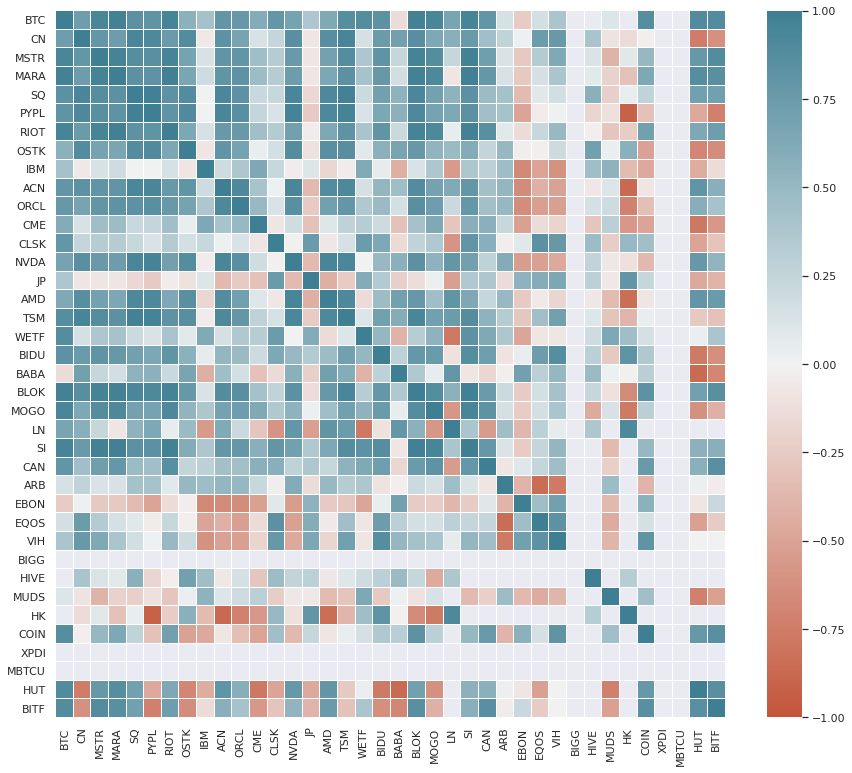

In [22]:
fig, ax = plt.subplots(figsize=(15, 13))
sns.heatmap(df.corr(), ax=ax, vmin=-1, vmax=1,
            cmap=sns.diverging_palette(20, 220, as_cmap=True),
            linewidths=.01)
plt.show()